In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import langevin
import langevin_cached_model as lcm
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar
import theano.tensor as tt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [4]:
class Ornstein_Uhlenbeck(pm.Continuous):
    """
    Ornstein-Uhlenbeck Process
    Parameters
    ----------
    B : tensor
        B > 0, B = exp(-(D/A)*delta_t)
    A : tensor
        A > 0, amplitude of fluctuation <x**2>=A
    delta_t: scalar
        delta_t > 0, time step
    """

    def __init__(self, A=None, B=None,
                 *args, **kwargs):
        super(Ornstein_Uhlenbeck, self).__init__(*args, **kwargs)
        self.A = A
        self.B = B
        self.mean = 0.

    def logp(self, x):
        A = self.A
        B = self.B

        x_im1 = x[:-1]
        x_i = x[1:]

        ou_like = pm.Normal.dist(mu=x_im1*B, tau=1.0/A/(1-B**2)).logp(x_i)
        return pm.Normal.dist(mu=0.0,tau=1.0/A).logp(x[0]) + tt.sum(ou_like)


In [5]:
A,D = 1.0,10.0
tau_real = A/D
delta_t_list=np.linspace(0.001,0.2,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))

In [6]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

result_Bayes_array = None
for delta_t in delta_t_list:
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult1(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

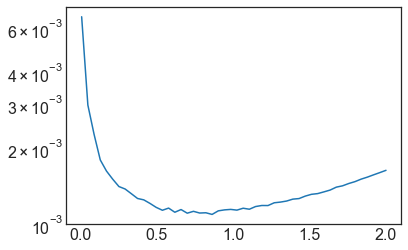

In [7]:
plt.semilogy(delta_t_list/tau_real,result_Bayes_array.T[3])

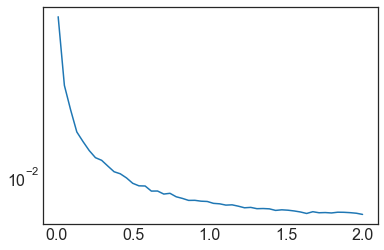

In [8]:
plt.semilogy(delta_t_list/tau_real,result_Bayes_array.T[1])

In [9]:
AA,DD = 1.0,10.0
tau_real = AA/DD
delta_t_list=np.linspace(0.001,0.2,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))
pick_delta = 7
print(delta_t_list[pick_delta])
data = langevin.time_series(A=AA, D=DD, delta_t=delta_t_list[pick_delta], N=N)

0.029428571428571432


In [10]:
d_bound=30
a_bound=3
delta_t=delta_t_list[pick_delta]
# compile model for reuse
with pm.Model() as model:
    D = pm.Uniform('D', lower=0, upper=d_bound)
    A = pm.Uniform('A', lower=0, upper=a_bound)

    B = pm.Deterministic('B', pm.math.exp(-delta_t * D / A))

    path = Ornstein_Uhlenbeck('path',A=A, B=B, observed=data)
    
    trace = pm.sample(20000,tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:50<00:00, 2374.37draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c21d4b748>,
      dtype=object)

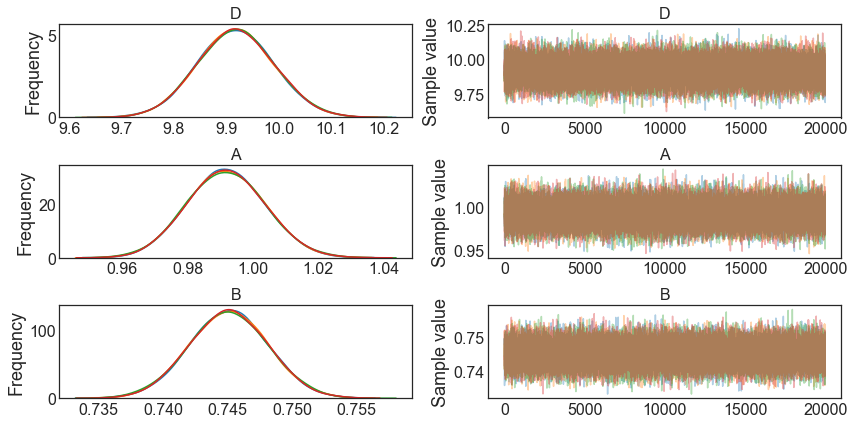

In [11]:
pm.traceplot(trace)

In [12]:
result_array = None
for delta_t in delta_t_list:
    print(delta_t)
    data = langevin.time_series(A=AA, D=DD, delta_t=delta_t, N=N)
    with pm.Model() as model:
        D = pm.Uniform('D', lower=0, upper=d_bound)
        A = pm.Uniform('A', lower=0, upper=a_bound)

        B = pm.Deterministic('B', pm.math.exp(-delta_t * D / A))

        path = Ornstein_Uhlenbeck('path',A=A, B=B, observed=data)
    
        trace = pm.sample(20000,tune=10000)
        
    a_mean = trace['A'].mean()
    d_mean = trace['D'].mean()
    a_std = trace['A'].std()
    d_std = trace['D'].std()
    results = [a_mean,a_std,d_mean,d_std]
    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))

0.001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:53<00:00, 2256.53draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


0.005061224489795919


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:54<00:00, 2199.88draws/s]
The acceptance probability does not match the target. It is 0.7126342326706007, but should be close to 0.8. Try to increase the number of tuning steps.


0.009122448979591836


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:50<00:00, 2357.85draws/s]


0.013183673469387758


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:52<00:00, 2297.54draws/s]


0.017244897959183676


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:52<00:00, 2294.83draws/s]


0.021306122448979593


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:51<00:00, 2322.48draws/s]


0.025367346938775515


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:49<00:00, 2406.06draws/s]


0.029428571428571432


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:54<00:00, 2199.99draws/s]


0.03348979591836735


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:49<00:00, 2414.55draws/s]


0.03755102040816327


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:49<00:00, 2430.88draws/s]


0.041612244897959186


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:49<00:00, 2434.74draws/s]


0.04567346938775511


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:49<00:00, 2402.52draws/s]


0.04973469387755103


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:50<00:00, 2398.24draws/s]


0.05379591836734694


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:50<00:00, 2376.30draws/s]
The acceptance probability does not match the target. It is 0.6947535212472162, but should be close to 0.8. Try to increase the number of tuning steps.


0.057857142857142864


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:49<00:00, 2424.00draws/s]


0.06191836734693878


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:49<00:00, 2424.93draws/s]


0.0659795918367347


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:49<00:00, 2433.98draws/s]


0.07004081632653061


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:58<00:00, 2055.43draws/s]
The acceptance probability does not match the target. It is 0.8795155185277355, but should be close to 0.8. Try to increase the number of tuning steps.


0.07410204081632654


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:51<00:00, 2335.09draws/s]


0.07816326530612246


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:51<00:00, 2332.49draws/s]


0.08222448979591837


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:53<00:00, 2256.15draws/s]


0.0862857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:53<00:00, 2261.28draws/s]


0.09034693877551021


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:54<00:00, 2191.02draws/s]


0.09440816326530613


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:56<00:00, 2134.25draws/s]


0.09846938775510206


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:56<00:00, 2129.53draws/s]


0.10253061224489797


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:53<00:00, 2227.33draws/s]


0.10659183673469388


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:51<00:00, 2347.87draws/s]


0.1106530612244898


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:52<00:00, 2284.03draws/s]


0.11471428571428573


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:50<00:00, 2359.90draws/s]


0.11877551020408164


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:50<00:00, 2364.10draws/s]


0.12283673469387756


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:50<00:00, 2364.26draws/s]


0.12689795918367347


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:55<00:00, 2163.78draws/s]


0.1309591836734694


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:50<00:00, 2356.05draws/s]


0.13502040816326533


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:50<00:00, 2366.77draws/s]


0.13908163265306123


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:53<00:00, 2254.63draws/s]
The acceptance probability does not match the target. It is 0.6945436235251434, but should be close to 0.8. Try to increase the number of tuning steps.


0.14314285714285716


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:51<00:00, 2347.86draws/s]


0.14720408163265308


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:51<00:00, 2348.90draws/s]


0.15126530612244898


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:55<00:00, 2171.77draws/s]
The acceptance probability does not match the target. It is 0.6598205736930193, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6821664249102051, but should be close to 0.8. Try to increase the number of tuning steps.


0.1553265306122449


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:50<00:00, 2377.15draws/s]


0.15938775510204084


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:52<00:00, 2265.12draws/s]


0.16344897959183674


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:52<00:00, 2296.13draws/s]


0.16751020408163267


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:55<00:00, 2169.91draws/s]


0.1715714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:53<00:00, 2252.55draws/s]


0.1756326530612245


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:52<00:00, 2281.83draws/s]


0.17969387755102043


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:57<00:00, 2089.22draws/s]


0.18375510204081635


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:52<00:00, 2274.51draws/s]


0.18781632653061225


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:55<00:00, 2147.06draws/s]


0.19187755102040818


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:52<00:00, 2291.58draws/s]


0.1959387755102041


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:54<00:00, 2190.14draws/s]
The acceptance probability does not match the target. It is 0.7079446415972251, but should be close to 0.8. Try to increase the number of tuning steps.


0.2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:52<00:00, 2285.69draws/s]


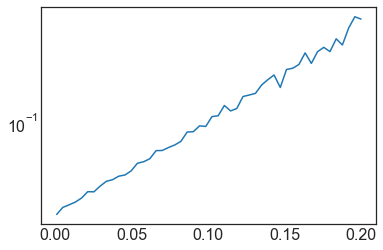

In [13]:
plt.semilogy(delta_t_list,result_array.T[3])

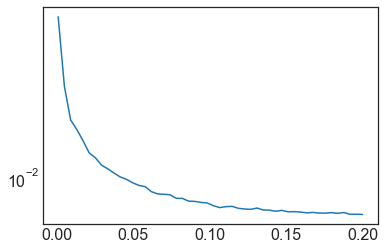

In [14]:
plt.semilogy(delta_t_list,result_array.T[1])

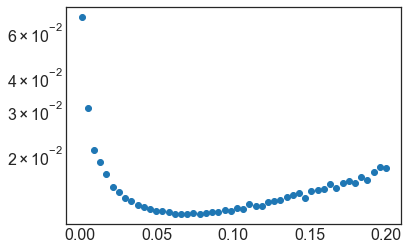

In [15]:
dtau = np.sqrt(result_array.T[1]**2/DD**2+AA**2/DD**4*result_array.T[3]**2)
plt.semilogy(delta_t_list,dtau/tau_real,"o")

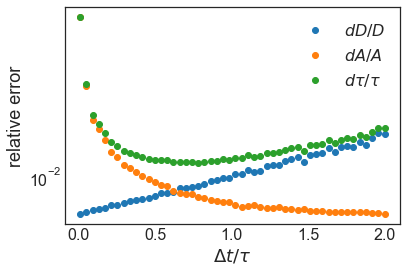

In [16]:
plt.semilogy(delta_t_list/tau_real,result_array.T[3]/DD,"o",label=r"$dD/D$")
plt.semilogy(delta_t_list/tau_real,result_array.T[1]/AA,"o",label=r'$dA/A$')
plt.semilogy(delta_t_list/tau_real,dtau/tau_real,"o",label=r'$d\tau/\tau$')
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend()

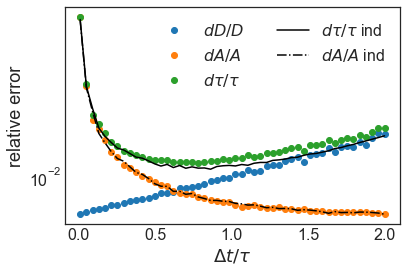

In [19]:
plt.semilogy(delta_t_list/tau_real,result_array.T[3]/DD,"o",label=r"$dD/D$")
plt.semilogy(delta_t_list/tau_real,result_array.T[1]/AA,"o",label=r'$dA/A$')
plt.semilogy(delta_t_list/tau_real,dtau/tau_real,"o",label=r'$d\tau/\tau$')
plt.semilogy(delta_t_list/tau_real,result_Bayes_array.T[3]/tau_real,color="k",label=r"$d\tau/\tau$ ind")
plt.semilogy(delta_t_list/tau_real,result_Bayes_array.T[1]/AA,"-.",color="k",label=r"$dA/A$ ind")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
#plt.xlim((0,4))
plt.legend(ncol=2)
plt.savefig("optimaldt_1_10.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [18]:
result_array.T[3]

array([0.06341707, 0.06567951, 0.06651086, 0.06741849, 0.06877213,
       0.07098208, 0.07094518, 0.07298964, 0.07474381, 0.07535427,
       0.07667802, 0.07712931, 0.07873787, 0.08176149, 0.08236957,
       0.08360895, 0.08702971, 0.08711427, 0.08838943, 0.08951301,
       0.09112603, 0.0954483 , 0.09562152, 0.0984196 , 0.09814593,
       0.10305888, 0.10350195, 0.10890047, 0.10600199, 0.10730411,
       0.11386986, 0.11471965, 0.11564795, 0.1205939 , 0.12380937,
       0.12669361, 0.11910718, 0.130202  , 0.1310271 , 0.13348745,
       0.14140437, 0.13419447, 0.14224939, 0.14535333, 0.14230704,
       0.15159875, 0.14707204, 0.15988831, 0.16918761, 0.16724023])

In [21]:
data_label = "1_10"
np.save("dtnorm_"+data_label,delta_t_list/tau_real)
np.save("dD_D_"+data_label,result_array.T[3]/DD)
np.save("dA_A_"+data_label,result_array.T[1]/AA)
np.save("dtau_tau_"+data_label,dtau/tau_real)
np.save("dtau_tau_ind_"+data_label,result_Bayes_array.T[3]/tau_real)
np.save("dA_A_ind_"+data_label,result_Bayes_array.T[1]/AA)
